In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time

In [60]:
"""
Idea is to index a 2D array using some 1D curve. Thus, there is an index mapping from each (x,y)->ind
Further, each site also has an adjancency set. This is the set of indices that are coupled to the site by an FM interaction
The model is defined using a 1xN field matrix and an NxN coupling matrix. The coupling matrix is sparse. N = LxW
"""
L= 3

def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def square_lattice_dictionary(L):
    
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_lattice_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))

            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind


ind_dict, adj_ind = triangle_lattice_dictionary(L)

def fill_J_ij_matrix(size, adj_ind, a, b):
    J_ij_vals = np.zeros(shape=(size, size))
    for ind in range(size):
        J_ij_vals[ind, adj_ind[ind]] = np.exp(-np.array(random_custDist(a, b, custDist=custDist, size=len(adj_ind[ind]))))
    
    J_ij_vals[np.triu_indices(J_ij_vals.shape[0], k = 1)] = 0
    
    return J_ij_vals+J_ij_vals.T

def linear_fit(x, m, b):
    return m*x + b
def power_law(x, a):
    return x**(-a)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def exponential_dist(x, A, b):
    return A*np.exp(-b*x)

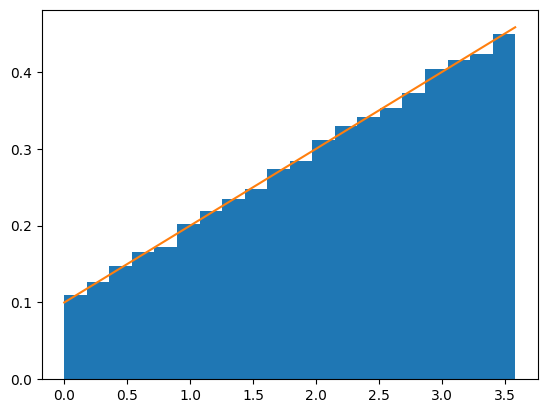

In [6]:
def random_custDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 2*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

#call
a=0.1
b=0.1
def custDist(x, a, b):
    return a + b*x
samples=random_custDist(a,b,custDist=custDist,size=100000)
#print(samples)

plt.hist(np.array(samples), density=True, bins = 20)

x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(custDist(x, a, b)))

In [7]:
def update_adjacency_J_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j]))
        
    return None

def update_adjacency_h(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i]))
        
    adj_ind[i] = []
    return None
    

[0.34083756]


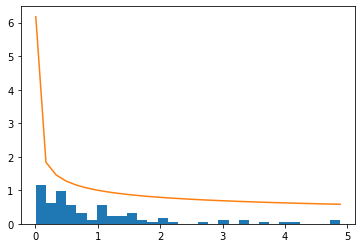

In [5]:
L = 10
ind_dict, adj_ind = square_lattice_dictionary(L)

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.1])#np.arange(0.1,0.3,0.03)


h_vals = np.exp(-np.random.exponential(size=L*L))
J_ij_vals = fill_J_ij_matrix(L*L, adj_ind, a, b)

n,bins, pacthes = plt.hist(-np.log(h_vals), density=True, bins = 30)

width = bins[1]-bins[0]

popt, pcov = curve_fit(power_law, bins[1:]-width/2, n)

plt.plot(bins, power_law(bins, *popt))
print(popt)

Step: 0/1500
Step: 500/1500
Step: 1000/1500


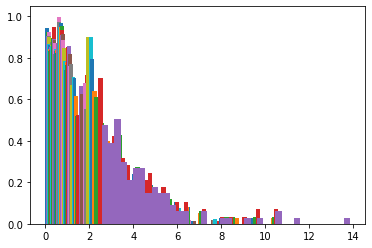

In [46]:
L = 40
steps = 1500
Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))
R0_array = []
R0_array_err = []


for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        
        ind_dict, adj_ind = square_lattice_dictionary(L)
        
        J_ij_vals = fill_J_ij_matrix(L*L, adj_ind, a, b)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        
        Omega_0 = max(h_vals.max(), J_ij_vals.max())
        for step in range(steps):
    
            if step%500 == 0: print ("Step: "+str(step)+"/"+str(steps))
            Omega = max(h_vals.max(), J_ij_vals.max())
            Gamma_array[l,m,step] = (np.log(Omega_0/Omega))

            if Omega == J_ij_vals.max():
                """
                Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                Delete one of the elements (say h_i), shortening h_vals
                Update adjacency of j to include both adj(i) and adj(j)
                Set new Jnew_jk = max (J_jk, J_ik)
                Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                """
                i_list, j_list = np.asarray(J_ij_vals == J_ij_vals.max()).nonzero()
                i = i_list[0]
                j = j_list[0]

                h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                h_vals[j] = 0

                update_adjacency_J_ij(adj_ind, i, j)

                J_ij_vals[i,adj_ind[i]] = np.maximum(J_ij_vals[i, adj_ind[i]], J_ij_vals[j, adj_ind[i]])
                J_ij_vals[adj_ind[i], i] = J_ij_vals[i,adj_ind[i]]

                J_ij_vals[j,:] = 0
                J_ij_vals[:,j] = 0

            elif Omega == h_vals.max():
                """
                """
                i = np.where(h_vals == h_vals.max())[0][0]
                adj_i = adj_ind[i]
                J_ij_new = np.einsum('j,k->jk', J_ij_vals[adj_i, i], J_ij_vals[i, adj_i])/Omega

                J_ij_vals[adj_i, :][:, adj_i] = np.maximum(J_ij_new, J_ij_vals[adj_i,:][:, adj_i])

                h_vals[i] = 0

                J_ij_vals[i,:] = 0
                J_ij_vals[:,i] = 0

                update_adjacency_h(adj_ind, i)
            
            if step%20 == 0:
                h_vals_remain = h_vals[h_vals!=0]

                n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 40)

                width = bins[1]-bins[0]
                popt, pcov = curve_fit(power_law, bins[1:]-width/2, n)
                R0_array.append(popt[0])
                R0_array_err.append(pcov[0][0])

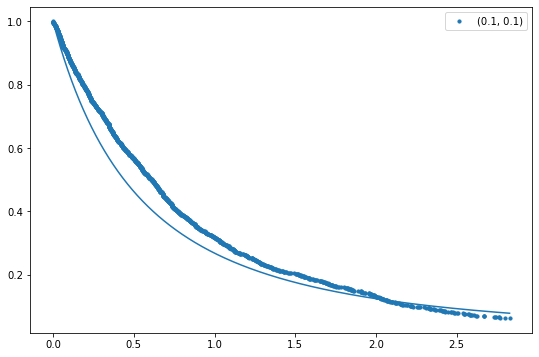

In [47]:
n_array = (- np.arange(steps)+(L*L))/(L*L)
plt.figure(figsize=(9, 6))
for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        plt.scatter(Gamma_array[l,m,:],  n_array, s=10, label="("+str(a)+', '+str(b)+")")
plt.plot(Gamma_array[0,0,:], (Gamma_array[0,0,:]+1)**(-1.9))
plt.legend()

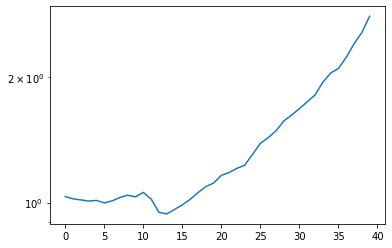

In [8]:
plt.errorbar(np.arange(len(R0_array)), 1/np.array(R0_array))#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
plt.yscale('log')

[0.54397943]
[[0.0708541]]


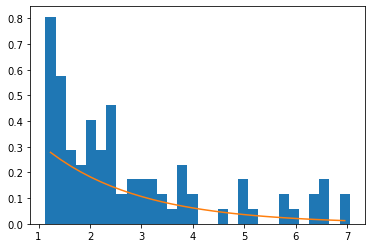

In [407]:
h_vals_remain = h_vals[h_vals>1e-4]

n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 30)

width = bins[1]-bins[0]


x_data = bins[1:]-width/2
popt, pcov = curve_fit(power_law,x_data, n)

plt.plot(x_data, power_law(x_data, *popt))
print(popt)
print(pcov)

[10.43487234 -5.94074295]


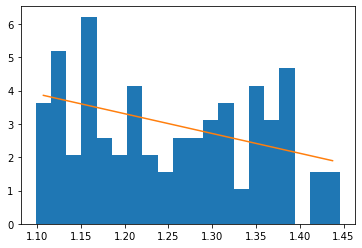

In [408]:
J_vals_remain = J_ij_vals[J_ij_vals!=0]
n,bins, pacthes = plt.hist(-np.log(J_vals_remain), density=True, bins = 20)
width = bins[1]-bins[0]
x_data = bins[1:]-width/2
popt, pcov = curve_fit(custDist, x_data, n)

plt.plot(x_data, custDist(x_data, *popt))
print(popt)
#print(pcov)

In [91]:
pacthes

<BarContainer object of 2 artists>

In [51]:
class Site:
    def __init__(self, ind, adj):
        self.ind = ind
        self.adj = adj
        return  None
    
    def add_adj_ind(self, adj_ext):
        self.adj = list(set(self.adj+adj_ext))
        return None
    
    def rm_adj_ind(self, adj_rm):
        self.adj = list(set(self.adj)-set(adj_rm))
        return None


In [245]:
L = 10

lat_ind, adj_ind = square_lattice_dictionary(L)

J_ij_vals = np.zeros(shape=(L*L,L*L))
h_vals = np.random.uniform(size=(L*L))

for ind in range(L*L):
    J_ij_vals[ind, adj_ind[ind]] = np.random.uniform(size=(1,len(adj_ind[ind])))
    
J = (J_ij_vals+ J_ij_vals.T)/2

Omega = h_vals.max()
#i,j = np.asarray(J == J.max()).nonzero()
i = np.where(h_vals == h_vals.max())[0][0]
i

66

In [246]:
def fill_J_ij_matrix(size, adj_ind, a, b):
    J_ij_vals = np.zeros(shape=(size, size))
    for ind in range(size):
        J_ij_vals[ind, adj_ind[ind]] = np.exp(-np.array(random_custDist(a, b, custDist=custDist, size=len(adj_ind[ind]))))
    
    J_ij_vals[np.triu_indices(J_ij_vals.shape[0], k = 1)] = 0
    
    return J_ij_vals+J_ij_vals.T

In [248]:
L = 40

ind_dict, adj_ind = square_lattice_dictionary(L)

X = fill_J_ij_matrix(L*L, adj_ind, 0.1, 0.1)


In [249]:
elements = []

for i in range(L):
    for j in range(L):
        if X[i,j]!=0: elements.append(X[i,j])

80


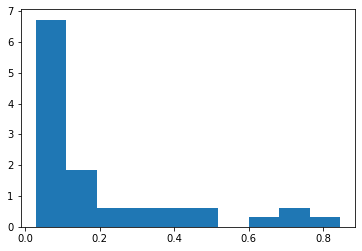

In [250]:
plt.hist(elements, density=True)
print(len(elements))

(array([0.22459831, 0.11229916, 0.21056092, 0.22459831, 0.21056092,
        0.29478529, 0.33689747, 0.32286008, 0.32286008, 0.54745839]),
 array([2.52293311e-03, 3.58714387e-01, 7.14905841e-01, 1.07109729e+00,
        1.42728875e+00, 1.78348020e+00, 2.13967166e+00, 2.49586311e+00,
        2.85205456e+00, 3.20824602e+00, 3.56443747e+00]),
 <BarContainer object of 10 artists>)

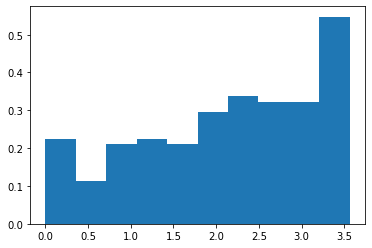

In [219]:
steps = 90
Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))
R0_array = []
R0_array_err = []


for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        
        ind_dict, adj_ind = square_lattice_dictionary(L)
        
        J_ij_vals = fill_J_ij_matrix(L*L, adj_ind, a, b)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        
        Omega_0 = max(h_vals.max(), J_ij_vals.max())
        for step in range(steps):
    
            if step%500 == 0: print ("Step: "+str(step)+"/"+str(steps))
            Omega = max(h_vals.max(), J_ij_vals.max())
            Gamma_array[l,m,step] = (np.log(Omega_0/Omega))

            if Omega == J_ij_vals.max():
                """
                Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                Delete one of the elements (say h_i), shortening h_vals
                Update adjacency of j to include both adj(i) and adj(j)
                Set new Jnew_jk = max (J_jk, J_ik)
                Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                """
                i_list, j_list = np.asarray(J_ij_vals == J_ij_vals.max()).nonzero()
                i = i_list[0]
                j = j_list[0]

                h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                h_vals[j] = 0

                update_adjacency_J_ij(adj_ind, i, j)

                J_ij_vals[i,adj_ind[i]] = np.maximum(J_ij_vals[i, adj_ind[i]], J_ij_vals[j, adj_ind[i]])
                J_ij_vals[adj_ind[i], i] = J_ij_vals[i,adj_ind[i]]

                J_ij_vals[j,:] = 0
                J_ij_vals[:,j] = 0

            elif Omega == h_vals.max():
                """
                """
                i = np.where(h_vals == h_vals.max())[0][0]
                adj_i = adj_ind[i]
                J_ij_new = np.einsum('j,k->jk', J_ij_vals[adj_i, i], J_ij_vals[i, adj_i])/Omega

                J_ij_vals[adj_i, :][:, adj_i] = np.maximum(J_ij_new, J_ij_vals[adj_i,:][:, adj_i])

                h_vals[i] = 0

                J_ij_vals[i,:] = 0
                J_ij_vals[:,i] = 0

                update_adjacency_h(adj_ind, i)
            
            if step%20 == 0:
                h_vals_remain = h_vals[h_vals!=0]

                n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 40)

                width = bins[1]-bins[0]
                popt, pcov = curve_fit(power_law, bins[1:]-width/2, n)
                R0_array.append(popt[0])
                R0_array_err.append(pcov[0][0])

In [8]:
from scipy import sparse
L = 4
ind_dict, adj_ind = square_lattice_dictionary(L)
a, b = (0.1, 0.1)

In [7]:
#J_ij_vals = fill_J_ij_matrix(L*L, adj_ind, a, b)

B=sparse.csr_matrix((L*L, L*L))

In [61]:
def fill_J_ij_matrix(size, adj_ind, a, b):
    J_ij_vals = sparse.lil_matrix((L*L, L*L))
    for ind in range(size):
        J_ij_vals[ind, adj_ind[ind]] = sparse.lil_matrix(np.exp(-np.array(random_custDist(a, b, custDist=custDist, size=len(adj_ind[ind])))))
        
    J_ij_vals = sparse.triu(J_ij_vals, k=1)
    
    return J_ij_vals + J_ij_vals.T

def chunk_deleter(ind_array, size):
    eye_diag = np.ones(size)
    eye_diag[ind_array] = 0
    return sparse.diags(eye_diag)

def resparse(spr_mat, size, tol):
    i_ind, j_ind, vals = sparse.find(spr_mat)
    mask = vals>tol
    i_new, j_new, val_new = i_ind[mask], j_ind[mask], vals[mask]
    
    return sparse.csr_matrix((val_new, (i_new, j_new)), shape=(size, size))

In [114]:
fill_J_ij_matrix(L, adj_ind, a, b)
ind_dict, adj_ind = square_lattice_dictionary(L)
J_ij_vals = fill_J_ij_matrix(L*L, adj_ind, a, b)

In [85]:
L = 100
steps = 6000
runs = 1
#R0_array_sum = np.zeros(int(steps/50))

cluster_tracker = np.ones(L*L)

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

for run in range(runs):
    Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))
    R0_array = []
    mu_array = []
    #R0_array_err = []

    t_total_Jij = 0
    t_total_h = 0

    for l, a in enumerate(a_vals):
        for m, b in enumerate(b_vals):

            ind_dict, adj_ind = triangle_lattice_dictionary(L)

            J_ij_vals = fill_J_ij_matrix(L*L, adj_ind, a, b)
            h_vals = np.exp(-np.random.exponential(size=L*L))

            Omega_0 = max(h_vals.max(), J_ij_vals.max())
            for step in range(steps):

                if step%1000 == 0: print ("Step: "+str(step)+"/"+str(steps))
                Omega = max(h_vals.max(), J_ij_vals.max())
                Gamma_array[l,m,step] = (np.log(Omega_0/Omega))
                #J_ij_vals = resparse(J_ij_vals, L*L, Omega*(1-steps/(L*L)))

                if Omega == J_ij_vals.max():
                    """
                    Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                    Delete one of the elements (say h_i), shortening h_vals
                    Update adjacency of j to include both adj(i) and adj(j)
                    Set new Jnew_jk = max (J_jk, J_ik)
                    Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                    """
                    t0 = time.time()
                    r_ind, c_ind, J_ij = sparse.find(J_ij_vals) 
                    J_ind = np.where(J_ij == Omega)[0][0]
                    i, j = r_ind[J_ind], c_ind[J_ind]

                    h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                    h_vals[j] = 0

                    update_adjacency_J_ij(adj_ind, i, j)

                    J_ij_vals[i,adj_ind[i]] = J_ij_vals[i, adj_ind[i]].maximum(J_ij_vals[j, adj_ind[i]])
                    J_ij_vals[adj_ind[i], i] = J_ij_vals[i,adj_ind[i]]

                    eye = chunk_deleter([j], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye
                    t_total_Jij += time.time()-t0
                    cluster_tracker[i] += cluster_tracker[j]
                    cluster_tracker[j] = 0
                elif Omega == h_vals.max():
                    """
                    """
                    t0 = time.time()
                    i = np.where(h_vals == h_vals.max())[0][0]
                    adj_i = adj_ind[i]
                    J_ij_new = J_ij_vals[adj_i, i] @J_ij_vals[i, adj_i]/Omega

                    J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(J_ij_vals[adj_i,:][:, adj_i])

                    h_vals[i] = 0

                    eye = chunk_deleter([i], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye

                    update_adjacency_h(adj_ind, i)
                    t_total_h += time.time()-t0
                if step%20 == 0:
                    h_vals_remain = h_vals[h_vals!=0]
                    cluster_moments = cluster_tracker[cluster_tracker!=0]
                    n,bins = np.histogram(-np.log(h_vals_remain), density=True, bins = 40)

                    width = bins[1]-bins[0]
                    popt, pcov = curve_fit(exponential_dist, bins[1:]-width/2, n)
                    R0_array.append(popt[1])
                    mu_array.append(cluster_moments.mean())
                    #R0_array_err.append(pcov[0][0])
    #R0_array_sum += np.array(R0_array)

Step: 0/6000
Step: 1000/6000
Step: 2000/6000
Step: 3000/6000
Step: 4000/6000
Step: 5000/6000


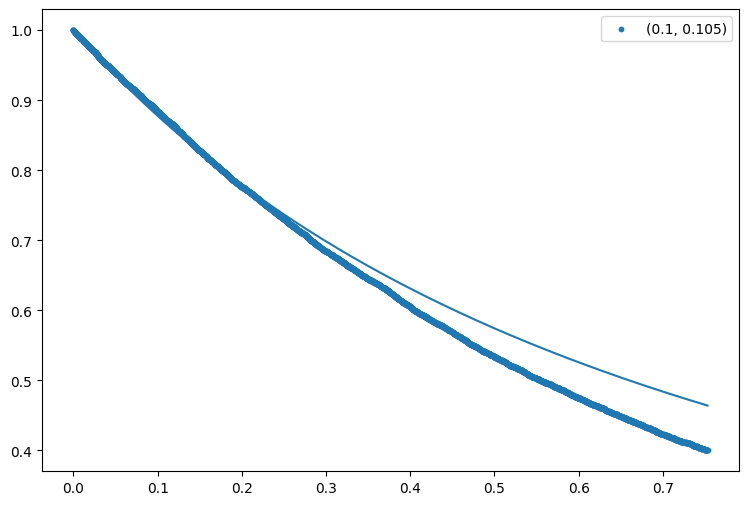

In [79]:
n_array = (- np.arange(steps)+(L*L))/(L*L)
plt.figure(figsize=(9, 6))
for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        plt.scatter(Gamma_array[l,m,:],  n_array, s=10, label="("+str(a)+', '+str(b)+")")
plt.plot(Gamma_array[0,0,:], (Gamma_array[0,0,:]+1)**(-1.368))



plt.legend()
#plt.xlim(0, 10)

[ 0.31029009 17.13964802]
0.6205801853841009


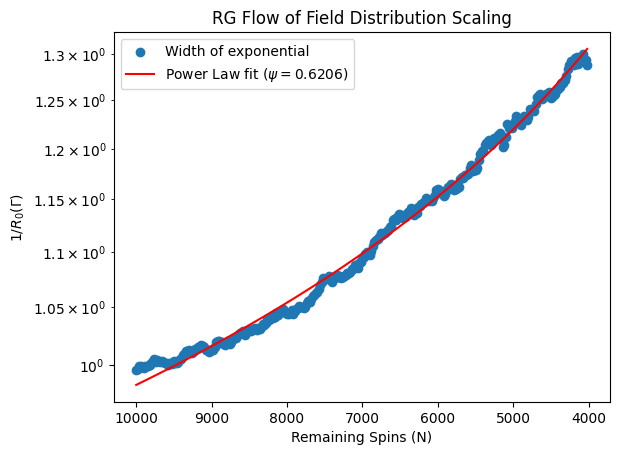

In [86]:
x = L*L - np.arange(len(R0_array))*20.0
y = runs/np.array(R0_array)

plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x, y)
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
#plt.ylim(0, 1.5)

[-0.17455018  1.61915477]


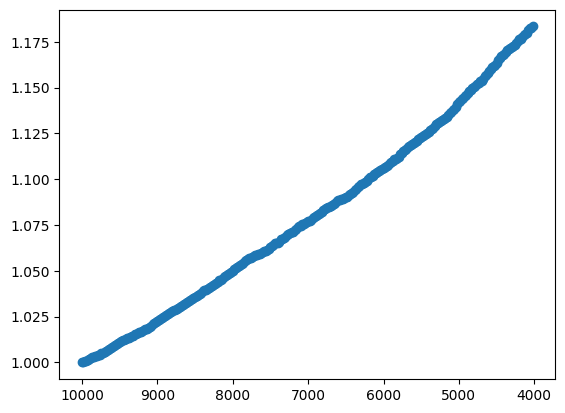

In [88]:
log_x = np.log(x)
log_mu = np.log(np.array(mu_array))

plt.scatter(np.exp(log_x), np.exp(log_mu))
plt.gca().invert_xaxis()

popt, pcov = curve_fit(linear_fit,log_x[100:] , log_mu[100:])

#plt.plot(log_x, linear_fit(log_x, *popt))
#plt.xscale('log')
#plt.yscale('log')
print(popt)

In [25]:
popt, pcov = curve_fit(power_law_scale, x[-150:], 1/np.array(R0_array)[-150:])
print(popt)
print(popt[0]*2)

[8.28500272e-01 8.51654087e+03]
1.6570005448906635


C:\Users\tsgau\AppData\Local\Temp\ipykernel_13980\2578980702.py:41: RuntimeWarning: overflow encountered in power
  return scale*x**(-a)


In [96]:
print(t_total_Jij)
print(t_total_h)

510.70387864112854
378.47939229011536


In [203]:
popt, pcov = curve_fit(power_law, Gamma_array[0,0,:]+1, n_array)
popt

array([1.36841463])

[1.48256195 0.80559606]


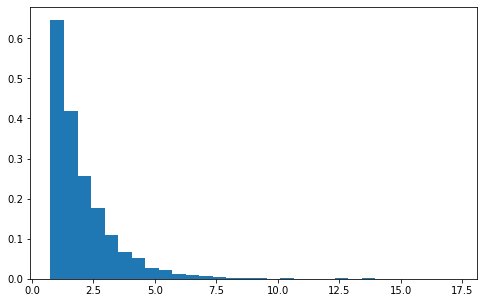

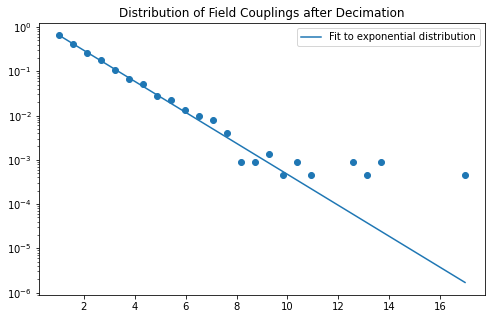

In [134]:
h_vals_remain = h_vals[h_vals!=0]
plt.figure(figsize=(8,5))
n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 30)

width = bins[1]-bins[0]

plt.figure(figsize=(8,5))
x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.scatter(x_data, n)
plt.title("Distribution of Field Couplings after Decimation")
plt.yscale('log')
plt.legend()
print(popt)

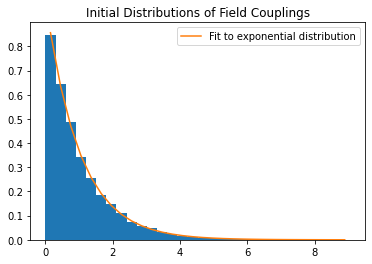

In [112]:
h_vals_ini = np.exp(-np.random.exponential(size=L*L))
n,bins, pacthes = plt.hist(-np.log(h_vals_ini), density=True, bins = 30)

width = bins[1]-bins[0]


x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.title("Initial Distributions of Field Couplings")
plt.legend()

0.36549707602339176

[1, 2, 3, 4]